In [1]:
from mpl_toolkits.basemap import Basemap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib
import itertools
import operator
import json
import sys
import os

pd.options.display.float_format = '{:.4g}'.format

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

py.init_notebook_mode(connected=True)

In [2]:
CITY = "spb"
CITY_CENTER = [59.9384, 30.3158]
OPPOSITE_CITY = "moscow"

In [12]:
with open("/Users/pavel/Sources/python/concepts/insta/cv_sandbox/age-gender-estimation/gender_ages_{}.json".format(CITY), "r") as f:
    data = json.load(f)

path = "/Users/pavel/Sources/python/concepts/insta/photos_{}/".format(CITY)
loc_file = list(map(lambda x: x.strip().split(","), open(path + "loc_info.csv", "r").readlines()[1:]))
id2loc = {x[0]: x[1] for x in loc_file}
locations = list(set(list(data)))
ids = list(data.keys())

min_photos = 10
genders_global = []
ages_global = []
dc = 0
for id in locations:

    if id in data:
        genders_data = data[id]['genders']
        ages_data = data[id]['ages']

        genders = list(itertools.chain(*genders_data.values()))
        ages = list(itertools.chain(*ages_data.values()))

        if len(genders_data) > min_photos:
            cnt = len(list(filter(lambda x: x < 0.5, genders)))
            genders_global.append([id,np.mean(genders), cnt])
            ages_global.append([id, np.percentile(ages, 25), np.median(ages), np.percentile(ages, 75)])
        else:
            dc+=1

In [4]:
gender_table = pd.DataFrame(genders_global, columns=['id', 'mean', 'count'])
ages_table = pd.DataFrame(ages_global, columns=['id', '25 per', '50 per', '75 per'])

In [5]:
fn1 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json".format(CITY)
fn2 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/age-gender-estimation/gender_ages.json"

with open(fn1, "r") as f:
    data1 = json.load(f)
    
with open(fn2, "r") as f:
    data2 = json.load(f)

In [6]:
def relevant_places(tag, n_top=100):
    d = {}
    for loc in list(data1.keys()):
        loc_val = 0
        for photo in data1[loc]:
            val = 0
            if tag in data1[loc][photo]['categories']:
                val = data1[loc][photo]['categories'][tag]
            loc_val += float(val)
        if loc_val > 0:
            d[loc] = loc_val
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)[:n_top]

### Areas & Streets

In [7]:
def area_normalize(s):
    stopword = "район"
    return s.replace(stopword, "").strip()


def street_normalize(s):
    return s.title()


fn = "/Users/pavel/Sources/python/concepts/insta/scripts/adresses_{}.csv".format(CITY)

AREA_COLUMN = 'state_district'
STREET_COLUMN = 'road'

geo_table = pd.read_csv(fn)
geo_table[AREA_COLUMN] = list(map(area_normalize, geo_table[AREA_COLUMN].tolist()))
geo_table[STREET_COLUMN] = list(map(street_normalize, geo_table[STREET_COLUMN].tolist()))

streets = geo_table[STREET_COLUMN].tolist()
areas = geo_table[AREA_COLUMN].tolist()

street_locations_n = sorted(Counter(streets).items(), 
                             key=operator.itemgetter(1), reverse=True)

area_locations_n = sorted(Counter(areas).items(), 
                           key=operator.itemgetter(1), reverse=True)
#

TOP_AREAS_N = 10
TOP_STREETS_N = 15

areas = [x[0] for x in area_locations_n[1:TOP_AREAS_N+1]] 
area_activity = [x[1] for x in area_locations_n[1:TOP_AREAS_N+1]]

streets = [x[0] for x in street_locations_n[1:TOP_STREETS_N+1]]
street_activity = [x[1] for x in street_locations_n[1:TOP_STREETS_N+1]]

In [8]:
N_TOP_AREAS = 5
HOLE = 0.5
PULL = 0.05
PIE_AREA_X = [0.1, 1.0]
PIE_AREA_Y = [0.5, 1.0]
BAR_CHART_OPACITY = 0.8
BAR_CHART_COLOR = 'red'
BAR_CHART_CM = "Wistia"
BAR_CHART_LEGEND_X = 0.55
BAR_CHART_LEGEND_Y = 0.0
OTHER_LABEL = "другое"

colormap = matplotlib.cm.get_cmap(BAR_CHART_CM)
norm_val = np.linspace(1.0, 0.2, N_TOP_AREAS + 1)
pieces_colors = list(map(lambda x: matplotlib.colors.rgb2hex(colormap(x)), 
                         norm_val))

data = [go.Bar(y=streets, 
                x=street_activity,
                marker=dict(color='red'), 
                orientation='h', 
                opacity=BAR_CHART_OPACITY, 
                showlegend=False),
        
        go.Pie(values=area_activity[:N_TOP_AREAS]+[sum(area_activity[N_TOP_AREAS+1:])],
                labels=areas[:N_TOP_AREAS]+[OTHER_LABEL],
                domain=dict(x=PIE_AREA_X, y=PIE_AREA_Y),
                hoverinfo="label+percent",
                textinfo='none', 
                hole=HOLE,
                sort=False,
                showlegend=True,
                marker=dict(colors=pieces_colors), 
                pull=PULL
              )]

FONT_SIZE = 11
TICK_LEN = 4
PLOT_HEIGHT = 350
PLOT_WIDTH = 900
BAR_CHART_AREA_X = [0, 0.25]
BAR_CHART_AREA_Y = [0, 1.0]
MARGIN = go.layout.Margin(l=220, t=30, b=30)

layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH, 
                   showlegend=True, margin=MARGIN, 
                   xaxis=dict(domain=BAR_CHART_AREA_X),
                   legend=dict(font=dict(size=FONT_SIZE, color='grey'),
                               yanchor='bottom', 
                               xanchor='center', 
                               x=BAR_CHART_LEGEND_X, 
                               y=BAR_CHART_LEGEND_Y),
                   font=dict(size=FONT_SIZE, color='grey'),
                   yaxis=dict(domain=BAR_CHART_AREA_Y, 
                              autorange="reversed", 
                              ticklen=TICK_LEN)
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, show_link=False)

In [22]:
import requests
from bs4 import BeautifulSoup


def get_street_coordinates(streets):
    request_template = "https://nominatim.openstreetmap.org/search.php?q={}&format=xml"
    street_coordinates = {}
    for x in streets:
        query = x.replace(" ", "+")
        request = requests.get(request_template.format(query))
        soup = BeautifulSoup(request.text, "lxml")
        place_tag = soup.find('place')
        street_coordinates[x] = [place_tag['lat'], place_tag['lon']]
    return street_coordinates


street_coordinates = get_street_coordinates(streets)

In [23]:
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']
MARKER_SIZE = 17
MARKER_OPACITY = 0.5
MARKER_COLOR = 'red'
ZOOM = 11
MARGIN = dict(l=0, r=30, b=0, t=20)
MAP_WIDTH = 700
MAP_HEIGHT = 400

lat = [x[0] for x in street_coordinates.values()]
lon = [x[1] for x in street_coordinates.values()]

data = [go.Scattermapbox(
            lat=lat,
            lon=lon,
            mode='markers',
            marker=dict(
                size=MARKER_SIZE,
                color=MARKER_COLOR,
                opacity=MARKER_OPACITY
            ),
            text=streets,
            hoverinfo='text')]

layout = go.Layout(
            width = MAP_WIDTH,
            height = MAP_HEIGHT,
            hovermode='closest',
            margin=MARGIN,
            mapbox=dict(
                accesstoken=MAPBOX_TOKEN,
                center=dict(
                    lat=CITY_CENTER[0],
                    lon=CITY_CENTER[1]
                ),
                zoom=ZOOM,
                style='light'
            ))

fig = dict(data=data, layout=layout)
py.iplot(fig, show_link=False)

###  Age & Gender

In [9]:
gender_result = gender_table.sort_values('mean', ascending=True)[['id', 'mean']].values.tolist()
age_result = ages_table.sort_values('25 per', ascending=True)[['id', '25 per']].values.tolist()

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:50]

In [10]:
N_SCENES = 25
SELECTED_TAGS = ['library/indoor', 'restaurant', 'street', 'bar', 
                 'discotheque', 'promenade', 'museum/indoor', 'art_gallery', 
                 'bridge', 'dressing_room', 'picnic_area', 'beer_hall', 
                 'skyscraper', 'bookstore', 'closet', 'television_studio', 
                 'stadium/soccer', 'pub/indoor', 'industrial_area', 'art_studio',
                 'lawn', 'highway', 'coffee_shop', 'booth/indoor', 'martial_arts_gym']

def get_tags(mode, top_scenes=None):
    if mode == "top":
        return [x[0] for x in top_scenes]
    elif mode == "selected":
        return SELECTED_TAGS
    
def trim(s, max_len=20):
    if len(s) <= max_len:
        return s
    else:
        s = s[:max_len].strip("_")
        return s + "..."

### Tags

In [11]:
gender_result = gender_table.sort_values('mean', ascending=True)[['id', 'mean']].values.tolist()
age_result = ages_table.sort_values('25 per', ascending=True)[['id', '25 per']].values.tolist()

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

top_scenes = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:N_SCENES]

tags = get_tags('selected', top_scenes)
scenes_result = sorted([[x, cn[x]] for x in tags], key=lambda x: x[1], reverse=True)

N_SKIP = 0
MAX_HOVER_LEN = 25

top_places = [relevant_places(key, 5) for key, _ in scenes_result][N_SKIP:]
id_list_to_name = lambda x: [trim(id2loc[y[0]], MAX_HOVER_LEN) for y in x]

data = [go.Bar(
            x=[x[0].split("/")[0] for x in scenes_result][N_SKIP:],
            y=[x[1] for x in scenes_result][N_SKIP:],
            marker = dict(color='deeppink'),
            text=[" <br>".join(id_list_to_name(x)) for x in top_places],
            hoverinfo="y+text",
    )]

layout = go.Layout(height=400, width=750, showlegend=False, xaxis = dict(tickangle=-90), 
                   margin=go.layout.Margin(t=30, b=130), font=dict(size=11))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, show_link=False)

In [105]:
fn3 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_{}.json".format(OPPOSITE_CITY)
with open(fn3, "r") as f:
    data3 = json.load(f)
    
cn = Counter()
for loc in list(data3.keys()):
    for photo in data3[loc]:
        for category, val in data3[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result2 = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)

d1 = {x[0]: x[1]/len(data1) for x in scenes_result}
d2 = {x[0]: x[1]/len(data3) for x in scenes_result2}

sc_delta_val = []
for x in d1:
    if x in d1 and x in d2:
        sc_delta_val.append([x, d1[x]-d2[x]])
    else:
        print("error", x, x in d1, x in d2)

sc_tags = [z[0] for z in sorted(scenes_result, key=lambda x: x[0])]

sc_delta = sorted(sc_delta_val, key=lambda x: abs(x[1]), reverse=True)[:25]
sc_delta = sorted(sc_delta, key=lambda x: x[1], reverse=False)

data = [go.Bar(
            x=[x[0] for x in sc_delta],
            y=[x[1] for x in sc_delta],
            marker = dict(color='mediumseagreen')
    )]

margin = go.layout.Margin(t=30, b=130, l=50)
layout = go.Layout(height=400, width=700, margin=margin,
                   showlegend=False, xaxis=dict(tickangle=-90, color='grey'), 
                   font=dict(size=11))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, show_link=False)

In [82]:
sorted_tags = [x[0] for x in scenes_result]

def build_tags_table():
    dd = []
    for loc in list(data1.keys()):
        cn = Counter()
        for photo in data1[loc]:
            for category, val in data1[loc][photo]['categories'].items():
                cn[category] += float(val)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


def calculate_street_vectors():
    keywords_table = build_tags_table()
    street_vectors = []
    for s in streets:
        sv = np.zeros(N_SCENES)
        locations_id = geo_table[geo_table[STREET_COLUMN]==s]['id'].astype(str)
        for loc in locations_id:
            if loc in keywords_table.id.values:
                is_relevant = keywords_table['id']==loc
                relevant_row = keywords_table[is_relevant][sorted_tags]
                location_vector = relevant_row.iloc[0].tolist()
                sv += location_vector

        street_vectors.append(sv)
    
    return np.array(street_vectors)

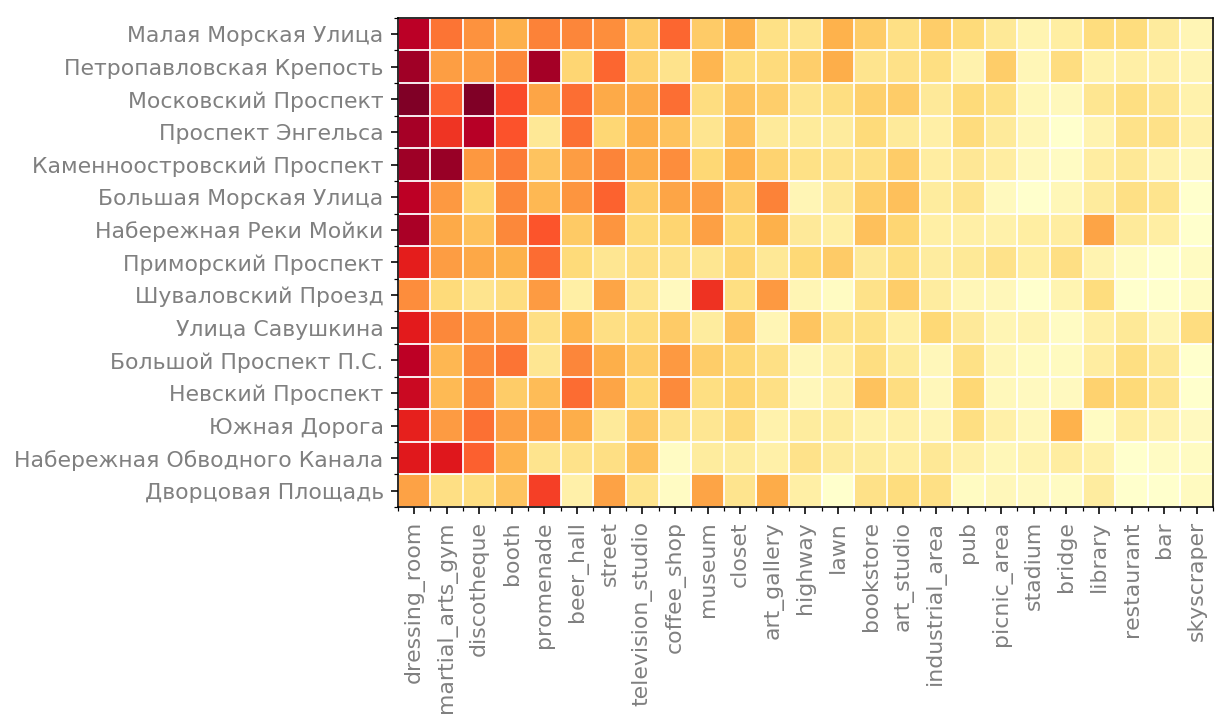

In [121]:
FONT_SIZE = 11
MAX_IM_VALUE = 7 # 20
COLORMAP = 'YlOrRd'
LABEL_COLOR = 'grey'
GRID_COLOR = 'white'
GRID_WIDTH = 0.9
PLT_WIDTH = 8.5
PLT_HEIGHT = 4.5

plt.figure(figsize=(PLT_WIDTH, PLT_HEIGHT))

labels = [x.split("/")[0] for x in sorted_tags]

street_vectors = calculate_street_vectors()
im = plt.imshow(street_vectors**0.5, cmap=COLORMAP, vmax=MAX_IM_VALUE)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, N_SCENES, 1), minor=True)
ax.set_yticks(np.arange(-0.5, TOP_STREETS_N, 1), minor=True)
plt.grid(which="minor", color=GRID_COLOR, linestyle='-', linewidth=GRID_WIDTH)

plt.xticks(range(N_SCENES), labels, rotation=90, size=FONT_SIZE, color=LABEL_COLOR)
plt.yticks(range(TOP_STREETS_N), streets, size=FONT_SIZE, color=LABEL_COLOR);

In [15]:
gender_ages_data = pd.merge(gender_table[['mean', 'id']], ages_table[['25 per', 'id']], on='id')


def stat_plot(vis_table1, value_name, target_column, color, inverse_value=False):
    dd = []
    for loc in list(data1.keys()):
        cn = Counter()
        for photo in data1[loc]:
            for category, val in data1[loc][photo]['categories'].items():
                cn[category] += float(val)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_info = pd.DataFrame(dd1)
    tags_info.columns=["id"] + tags

    vis_table1 = pd.merge(vis_table1, tags_info, on='id')

    x, y1, y2, y3, y4 = [],[],[],[],[]

    if inverse_value:
        vis_table1[target_column] = 1 - vis_table1[target_column]
    
    #rc = '50 per'
    th1 = np.percentile(vis_table1[target_column], 25)
    th2 = np.percentile(vis_table1[target_column], 50)
    th3 = np.percentile(vis_table1[target_column], 75)
    
    for tag in tags:
        try:

            val1 = sum(vis_table1[vis_table1[target_column]<th1][tag])
            val2 = sum(vis_table1[(vis_table1[target_column]>=th1) 
                                  & (vis_table1[target_column]<th2)][tag])
            val3 = sum(vis_table1[(vis_table1[target_column]>=th2) 
                                  & (vis_table1[target_column]<th3)][tag])
            val4 = sum(vis_table1[vis_table1[target_column]>=th3][tag])
            if val1 or val2 or val3 or val4:
                y1.append(val1)
                y2.append(val2)
                y3.append(val3)
                y4.append(val4)
                x.append(tag.split("/")[0])
            else:
                print("error: {}".format(tag))
                pass
        except:
            pass

    y1, y2, y3, y4 = np.array(y1), np.array(y2), np.array(y3), np.array(y4)

    y_sum = y1 + y2 + y3 + y4
    y1 /= y_sum
    y2 /= y_sum
    y3 /= y_sum
    y4 /= y_sum

    ids = np.flip(np.argsort(y1+y2, axis=0), axis=0)
    x = np.array(x)

    marker_style = dict(color=color)

    data = [
            go.Bar(x=x[ids], y=y1[ids], name="{} < p<sub>25</sub>".format(value_name),
                    hoverinfo="y", marker=marker_style),

            go.Bar(x=x[ids], y=y2[ids], 
                   name="p<sub>25</sub> < {} < p<sub>50</sub>".format(value_name),
                    hoverinfo="y", marker=marker_style, opacity=0.75),

            go.Bar(x=x[ids], y=y3[ids], 
                   name="p<sub>50</sub> < {} < p<sub>75</sub>".format(value_name),
                    hoverinfo="y", marker=marker_style, opacity=0.5),

            go.Bar(x=x[ids], y=y4[ids], 
                   name="{} > p<sub>75</sub>".format(value_name),
                    hoverinfo="y",marker=marker_style, opacity=0.25)
            ]

    layout = go.Layout(height=250, width=750, xaxis=dict(tickangle=-90, color='grey'),
                       margin=go.layout.Margin(t=30, b=130,l=50),
                       showlegend=True, font=dict(size=11), barmode='stack')

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, show_link=False)

    
stat_plot(gender_table, 'G', 'mean', 'dodgerblue', True)
stat_plot(ages_table, 'A', '50 per', 'lightseagreen', False)

In [16]:
antropos_table = pd.merge(ages_table[['id', '50 per']],
                          gender_table[['id', 'mean']],
                          on='id')

tags_table = build_tags_table()
complex_table = pd.merge(antropos_table, tags_table, on='id')
tag_vectors = complex_table[tags].values.tolist()
visual_data = TSNE().fit_transform(tag_vectors)
visual_data = visual_data.T

In [17]:
def short_tags():
    return [x.split("/")[0] for x in tags]


def make_readable(s):
    return trim(s.replace("_", " "))


def build_annotations():
    
    def calculate_centers():
        centers = []
        for tag in tags:
            threshold = np.mean(complex_table[tag][complex_table[tag]>0].tolist())
            xc = np.median(visual_data[0][complex_table[tag]>threshold])
            yc = np.median(visual_data[1][complex_table[tag]>threshold])
            centers.append([xc, yc])
        return centers

    def closest_node(node, nodes):
        nodes = np.asarray(nodes)
        dist_2 = np.sum((nodes - node)**2, axis=1)
        return np.argmin(dist_2)
    
    def dist(p1, p2):
        p1, p2 = np.array(p1), np.array(p2)
        return np.sqrt(np.sum((p1 - p2)**2))
    
    centers = calculate_centers()
    
    annotations = []
    annotation_labels = short_tags()
    for j in range(len(centers)):
        x, y = centers[j] 
        other_centers = centers[:j] + centers[j+1:]
        closest_idx = closest_node(centers[j], other_centers)
        if dist(centers[j], centers[closest_idx]) > MIN_DISTANCE:
            annotations.append(
                go.layout.Annotation(
                    x=x, 
                    y=y, 
                    xanchor="center",
                    showarrow=False,
                    text="<b>{}</b>".format(annotation_labels[j]),
                    opacity=ANNOTATION_OPACITY,
                    bgcolor="white",
                    #bordercolor='grey',
                    font=dict(family='Helvetica',size=FONT_SIZE, color=FONT_COLOR)))
            
    return annotations

In [18]:
X_young_girls, Y_young_girls, young_girls_labels = [], [], []
X_young_boys, Y_young_boys, young_boys_labels = [], [], []
X_old_girls, Y_old_girls, old_girls_labels = [], [], []
X_old_boys, Y_old_boys, old_boys_labels = [], [], []

GENDER_TRESHOLD = np.median(complex_table['mean'])
AGE_TRESHOLD = np.median(complex_table['50 per'])

for j, location_id in enumerate(complex_table['id'].tolist()):
    relevant_row = complex_table['id'] == location_id
    xval = visual_data[0][relevant_row][0]
    yval = visual_data[1][relevant_row][0]
    label = make_readable(id2loc[location_id])
    
    if complex_table.iloc[j]['mean'] <= GENDER_TRESHOLD and \
       complex_table.iloc[j]['50 per'] <= AGE_TRESHOLD:
            
        X_young_girls.append(xval)
        Y_young_girls.append(yval)
        young_girls_labels.append(label) 
        
    elif complex_table.iloc[j]['mean'] > GENDER_TRESHOLD and \
         complex_table.iloc[j]['50 per'] <= AGE_TRESHOLD:
            
        X_young_boys.append(xval)
        Y_young_boys.append(yval)
        young_boys_labels.append(label) 
        
    elif complex_table.iloc[j]['mean'] <= GENDER_TRESHOLD and \
         complex_table.iloc[j]['50 per'] > AGE_TRESHOLD:
            
        X_old_girls.append(xval)
        Y_old_girls.append(yval)
        old_girls_labels.append(label) 
            
    elif complex_table.iloc[j]['mean'] > GENDER_TRESHOLD and \
         complex_table.iloc[j]['50 per'] > AGE_TRESHOLD:
            
        X_old_boys.append(xval)
        Y_old_boys.append(yval)
        old_boys_labels.append(label) 

MARKER_SIZE = 5
MARKER_OPACITY = 0.6
BOYS_COLOR = 'dodgerblue'
GIRLS_COLOR = 'red'

young_girls_marker = dict(size=MARKER_SIZE, opacity=MARKER_OPACITY, 
                          color=GIRLS_COLOR, symbol='circle')
young_boys_marker = dict(size=MARKER_SIZE, opacity=MARKER_OPACITY, 
                         color=BOYS_COLOR, symbol='circle')
old_girls_marker = dict(size=MARKER_SIZE, opacity=MARKER_OPACITY, 
                        color=GIRLS_COLOR, symbol='diamond')
old_boys_marker = dict(size=MARKER_SIZE, opacity=MARKER_OPACITY, 
                       color=BOYS_COLOR, symbol='diamond')

X_set = [X_young_girls, X_young_boys, X_old_girls, X_old_boys]
Y_set = [Y_young_girls, Y_young_boys, Y_old_girls, Y_old_boys]
labels_set = [young_girls_labels, young_boys_labels, old_girls_labels, old_boys_labels]
markers_set = [young_girls_marker, young_boys_marker, old_girls_marker, old_boys_marker]
titles = ['young girls' ,'young boys', 'old girls', 'old boys']

data = []
for k in range(4):
    data.append(go.Scatter(x=X_set[k], y=Y_set[k], 
                   text=labels_set[k], 
                   marker=markers_set[k],
                   name=titles[k], 
                   mode='markers',
                   hoverinfo='text'))
    
MARGIN = dict(l=0, r=30, b=0, t=20)
PLOT_HEIGHT = 450
PLOT_WIDTH = 700

axis_style = dict(showticklabels=False, zeroline=False, showgrid=False)
layout = go.Layout(height=PLOT_HEIGHT, width=PLOT_WIDTH,
                    margin=MARGIN, hovermode='closest',
                    xaxis=axis_style, yaxis=axis_style)

fig = go.Figure(data=data, layout=layout)

FONT_COLOR = 'black'
MIN_DISTANCE = 10
FONT_SIZE = 16
ANNOTATION_OPACITY = 0.75

fig['layout']['annotations'] = build_annotations()

py.iplot(fig, show_link=False)